# Introduction to text classification

Text classification is becoming a common solution to many problems in industry today including chatbots, sentiment analysis, document tagging, recommendations, etc. This article will focus on utilizing [scikit-learn](http://scikit-learn.org), a mature machine library in Python and a relatively new library from Facebook AI Reasearch called [fastText](https://fasttext.cc/) in order to give an example of how to implement a text classification model.

The data we will be using today is publicly available [reddit](http://reddit.com/) data available [here in a Google BigQuery repository](https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_posts?pli=1). For today's problem, we're interested in being able to take the "title" of a post and predict which subreddit that post came from. If you are unfamiliar with reddit and want to know what I'm talking about, head on to [reddit](https://www.reddit.com/) to find out. We are going to be limiting our categories to 36 popular computer science/software development related subreddits because it gives us a relatively non-trivial number of classes and also gives us related categories that are going to be challenging to separate.

The data used here is provided in this page's [GitHub repository](https://github.com/victorkwak/FastTextEnsemble) so no need to separately download the data to follow this tutorial and using Google Cloud to download data is out of the scope of this article.

## Setup

I recommend downloading [Anaconda](https://www.anaconda.com/download/) for the base Python libraries needed for this tutorial. You will also need to download fastText available from their [GitHub repository](https://github.com/facebookresearch/fastText).

## Reading in the data

We will be using [pandas](https://pandas.pydata.org/) in order to read in the data.

In [9]:
import pandas as pd

data = pd.read_csv('../data/reddit.csv')

print('Number of unique subreddits in the dataset:', len(data['subreddit'].unique()))
print('Number of title posts in dataset:', data.shape[0])
data.sample(10)

Number of unique subreddits in the dataset: 36
Number of title posts in dataset: 69632


title  score  \
12600  Advice/Help: Inner vlan routing multiple switches     13   
39429  (gri) math/bits: added package for bit-level c...     20   
31116  Project Managers/Team Leads redditors, what so...    290   
48174  My school canceled their computer science program     13   
10135                                VPN recommendations     65   
20451  Hey Google, Please Copy These Apple TV 4K Anno...    974   
11097                         I3 Instances Available Now     39   
22693  Google Promises Chrome Browser Can and Will Do...     35   
43473  AR with Swift: How to make a UIView follow an ...      8   
5987              Writing a Node.js module in Typescript     14   

               subreddit  
12600         networking  
39429             golang  
31116   learnprogramming  
48174  cscareerquestions  
10135                mac  
20451            Android  
11097                aws  
22693             chrome  
43473     iOSProgramming  
5987          javascript

## Splitting up the data into train and test

We will be splitting up our data into training(70%) and test(30%).

In [10]:
from sklearn.model_selection import train_test_split

X = data['title']
y = data['subreddit']
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X, y, test_size=0.3, random_state=17)
print('Training set size:', X_train.shape[0])
print('Test set size:', X_test.shape[0])

Training set size: 48742
Test set size: 20890


In [11]:
X.sample(10)

32117    I started learning Javascript and Java on code...
53307                              [Feature]? Is this new?
25247        Javascript : The Curious Case of Null &gt;= 0
10511              Looking for an old Mac game circa 1995~
33057    My first basic python project. Would really ap...
65170           Vaadin Framework 8 : Java Web UI Framework
46137                       What can C do that Rust can't?
59504                          You will gain 50 Windows XP
58578    I reverse-engineered the function that's run w...
393                Nice interview about Pycharm's debugger
Name: title, dtype: object

In [12]:
y.sample(10)

8311               windows
56348             javahelp
30712     learnprogramming
12868           networking
34677          learnpython
34297          learnpython
63628              reactjs
38036       linuxquestions
48618    cscareerquestions
37328       linuxquestions
Name: subreddit, dtype: object

## Creating numerical data from text

In order for scikit-learn to process the data, everything including the class labels (subreddits in this case) need to be converted to numerical values. scikit-learn's `LabelEncoder` allows you to map unique class labels to numbers and transform them back to their original string values if you want to later on.

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['subreddit'])

y_train = label_encoder.transform(y_train_text)
y_test = label_encoder.transform(y_test_text)

print('Before encoding:\n', y_train_text.head(5), sep='')
print('\nAfter encoding:\n', y_train[0:5], sep='')

Before encoding:
57481     AskNetsec
6462     javascript
427          Python
67641    hackernews
30308    androiddev
Name: subreddit, dtype: object

After encoding:
[ 1 21  3 14  5]


We 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

Best Cross-validation accuracy: 0.5813437135243519
Best C: 0.2777777777777778


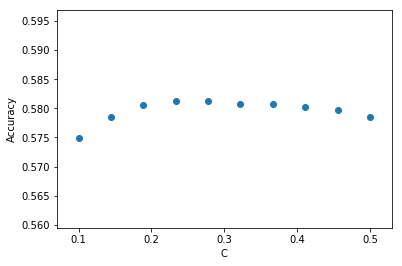

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
c_vals = np.linspace(0.1, 0.5, num=10)
for c in c_vals:
    svm = LinearSVC(C=c, max_iter=1000)
    scores.append(np.mean(cross_validate(svm, X_train_vectors, y_train, scoring='accuracy', cv=5, n_jobs=-1)['test_score']))
    
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(x=c_vals, y=scores)
best_c = c_vals[np.argmax(scores)]
print('Best Cross-validation accuracy:', np.max(scores))
print('Best C:', best_c)

In [11]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

svm = LinearSVC(C=best_c, max_iter=1000)
svm.fit(X_train_vectors, y_train)
svm_predictions = svm.predict(X_test_vectors)
print('Test accuracy:', accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))

Test accuracy: 0.5920057443752992
                   precision    recall  f1-score   support

          Android       0.75      0.90      0.82      2047
        AskNetsec       0.59      0.39      0.47       326
  ProgrammerHumor       0.31      0.31      0.31       628
           Python       0.53      0.43      0.47       428
        Windows10       0.56      0.55      0.55       675
       androiddev       0.67      0.58      0.62       565
    androidthemes       0.70      0.62      0.65       508
          arduino       0.81      0.71      0.76       371
              aws       0.79      0.82      0.81       388
           chrome       0.65      0.75      0.69       463
cscareerquestions       0.59      0.81      0.68      1105
          csshelp       0.78      0.81      0.80       350
      datascience       0.62      0.58      0.60       322
           golang       0.65      0.41      0.50       336
       hackernews       0.51      0.43      0.47       813
          haskell    

In [ ]:
from gensim import utils

def format_for_fastext(X, y, filename):
    prefix = '__label__'
    f = open(''.join(['data/', filename]), 'w')
    for title, label in zip(X, y):
        title = title.lower()
        tokens = utils.simple_preprocess(title)
#         tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]
        f.write(''.join([prefix, str(label), ' ', ' '.join(tokens), '\n']))
    f.close()
    
format_for_fastext(X_train, y_train, 'reddit_fasttext_train.txt')

In [ ]:
def test_fasttext(y, X, classifier, n=1):
    match = []
    for true, string in zip(y, X):
        predictions = list(classifier.predict(string, n)[0])
        for i in range(n):
            predictions[i] = int(predictions[i].split('__label__')[1])
        match.append(int(true in predictions))
    return np.array(match)

In [ ]:
import fastText

classifier = fastText.train_supervised(input='data/reddit_fasttext_train.txt',
                                 lr=0.1,
                                 epoch=30,
                                 dim=64,
                                 minn=2,
                                 maxn=5
                                )

correct = test_fasttext(y_val, X_val, classifier)
correct.sum() / y_val.size